In [2]:
%cd ~/NetBeansProjects/ExpLosion/
from itertools import chain
from notebooks.common_imports import *
from gui.output_utils import *
from gui.user_code import pretty_names

sns.timeseries.algo.bootstrap = my_bootstrap
sns.categorical.bootstrap = my_bootstrap

/Volumes/LocalDataHD/m/mm/mmb28/NetBeansProjects/ExpLosion


In [8]:
d = {'expansions__vectors__rep': 0, 
    'expansions__k':3,
    'labelled':'amazon_grouped-tagged',
    'expansions__use_similarity': 0, 
    'expansions__neighbour_strategy':'linear',
    'expansions__vectors__dimensionality': 100, 
    'document_features_ev': 'AN+NN', 
    'document_features_tr': 'J+N+AN+NN', 
    'expansions__allow_overlap': False,
    'expansions__entries_of': None,
    'expansions__vectors__algorithm': 'word2vec',
    'expansions__vectors__composer': 'Add',
    'expansions__vectors__unlabelled__in': ['wiki', 'cwiki'],
    'expansions__decode_handler': 'SignifiedOnlyFeatureHandler',
    'expansions__noise': 0}
unconstrained_ids = Experiment.objects.filter(**d).values_list('id', flat=True)

constrained_ids = Experiment.objects.filter(expansions__entries_of__isnull=False,
                                                expansions__entries_of__unlabelled_percentage__in=[1, 10],
                                                expansions__vectors__composer='Add').values_list('id', flat=True)



In [9]:
names = {'percent':'expansions__vectors__unlabelled_percentage',
         'reduced_to':'expansions__entries_of__unlabelled_percentage',
        'composer':'expansions__vectors__composer',
        'unlab':'expansions__vectors__unlabelled'}
df = dataframe_from_exp_ids(list(constrained_ids) + list(unconstrained_ids), names).convert_objects(convert_numeric=True)

Accuracy has 15000 values
composer has 15000 values
folds has 15000 values
unlab has 15000 values
percent has 15000 values
reduced_to has 15000 values


In [10]:
# convert percentages to token counts
def computer_token_count(row):
    corpus_sizes = {'cwiki': 525000000, 'wiki':1500000000}
    return corpus_sizes[row.unlab] * (row.percent / 100)

# put together a legible name for the method
def legible_name(row):
    if row.unlab == 'cwiki':
        return 'clean wiki (Add)'
    else:
        if np.isnan(row.reduced_to):
            return 'wiki (%s)'%row.composer
        else:
            return 'wiki 100 --> wiki %d (%s)'%(row.reduced_to, row.composer)
    
df['Tokens'] = df.apply(computer_token_count, axis=1)
df['name'] = df.apply(legible_name, axis=1)
df = df.drop('percent reduced_to unlab'.split(), axis=1)

In [11]:
df.head()

,Accuracy,composer,folds,Tokens,name
0,0.426929,Add,0,300000000,wiki 100 --> wiki 1 (Add)
1,0.427084,Add,1,300000000,wiki 100 --> wiki 1 (Add)
2,0.427240,Add,2,300000000,wiki 100 --> wiki 1 (Add)
3,0.428094,Add,3,300000000,wiki 100 --> wiki 1 (Add)
4,0.428250,Add,4,300000000,wiki 100 --> wiki 1 (Add)


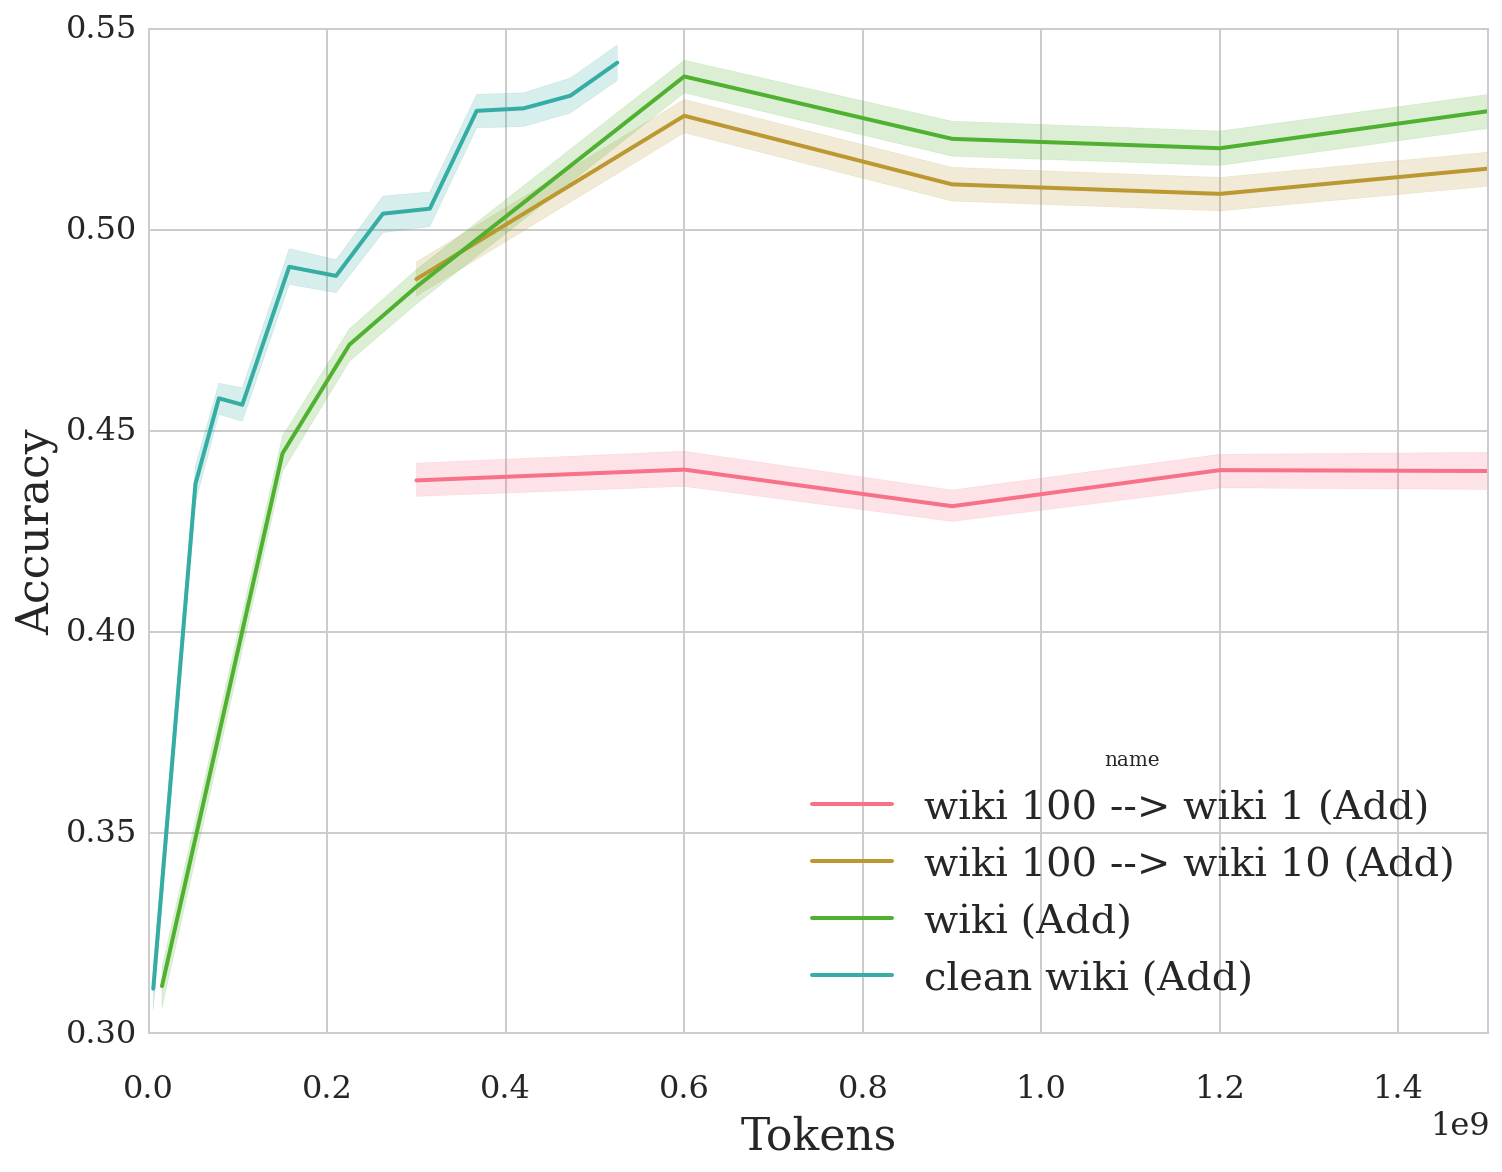

In [12]:
with sns.color_palette("husl", 6):
    ax = sns.tsplot(df, time='Tokens', unit='folds', condition='name', value='Accuracy')
ax.set_xlim(0, df.Tokens.max());
plt.savefig('plot-w2v_funky_learning_curves_amazon.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)